In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import tensorflow as tf
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import StandardScaler # Standardization
from sklearn.ensemble import IsolationForest # Outlier Detection
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam # Optimizer
from kerastuner.tuners import RandomSearch # HyperParameter Tuning
import warnings
warnings.filterwarnings('ignore') # To ignore warnings

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.


### Combine Data
I combined the train and test data to make it easier being checking data integrity

In [92]:
#Load data
train = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")
y = train['SalePrice'].values


#combine train and test dataset by rows
data = pd.concat([train,test],axis = 0, sort = False)

#drop sale price, Id columns
data.drop(['SalePrice', 'Id'], axis = 1,inplace = True)

#Check null value
pd.set_option('display.max_rows', 100)
missing_values = data.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending = False)
missing_values

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
FireplaceQu     1420
LotFrontage      486
GarageFinish     159
GarageQual       159
GarageCond       159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Functional         2
Utilities          2
GarageArea         1
GarageCars         1
Electrical         1
KitchenQual        1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF2         1
BsmtFinSF1         1
Exterior2nd        1
Exterior1st        1
SaleType           1
dtype: int64

### Data Integrity
First, I wanted to check the data integrity to provide a better quality of training data

In [3]:
#Check data type
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

### Fill Up NA Values
Fill up NA values base on different type variables

In [93]:
#fill up the NA values
#all NA values in Basement will be replaced with 0 to show no basement
data['BsmtFinSF1'].fillna(0, inplace=True)
data['BsmtFinSF2'].fillna(0, inplace=True)
data['TotalBsmtSF'].fillna(0, inplace=True)
data['BsmtUnfSF'].fillna(0, inplace=True)

#fill Electrical up with most common value
data['Electrical'].fillna('FuseA',inplace = True)

#fill KitchenQual up with most common value
data['KitchenQual'].fillna('TA',inplace=True)

#fill LotFrontage up with the mean of the LotFrontage of all groups having the same values of 1stFlrSF 
#because LotFrontage has high corretion with 1stFlrSF
#for the rest of NA, use linear interpolate to fill it up
data['LotFrontage'].fillna(data.groupby('1stFlrSF')['LotFrontage'].transform('mean'),inplace=True)
data['LotFrontage'].interpolate(method='linear',inplace=True)

#fill MasVnrArea up  
data['MasVnrArea'].fillna(data.groupby('MasVnrType')['MasVnrArea'].transform('mean'),inplace=True)
data['MasVnrArea'].interpolate(method='linear',inplace=True)

#fill others up. If numeric ones I use mean, categorical use NA
#list columns
NAN_col = list(missing_values.to_dict().keys())
for col in NAN_col:
    data_type = data[col].dtype
    if data_type == 'object':
        data[col].fillna('NA', inplace=True)
    else:
        data[col].fillna(data[col].mean(),inplace=True)

In [94]:
#check NA value
missing_values = data.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending = False)
missing_values

Series([], dtype: int64)

### Dummy Categorical Variables
Used Pandas `get_dummies()` to dummy categorical variables

In [95]:
#get categorical into dummy
data = pd.get_dummies(data)

#check shape
data.shape

(2919, 309)

In [7]:
#check data
data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_NA,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,0,0,0,1,0,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,0,0,0,1,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,0,0,0,1,0,0,0,0,1,0


### Prepare the Training Data
Split the data back to train and test data shape

In [96]:
#split train and test
train = data[:1460].copy()
test = data[1460:].copy()
train['SalePrice'] = y
test.shape

(1459, 309)

### Use Heatmap to Find Top Variables
First, I want to detect the top features of variables and manually check and adjust the outliers

<AxesSubplot:>

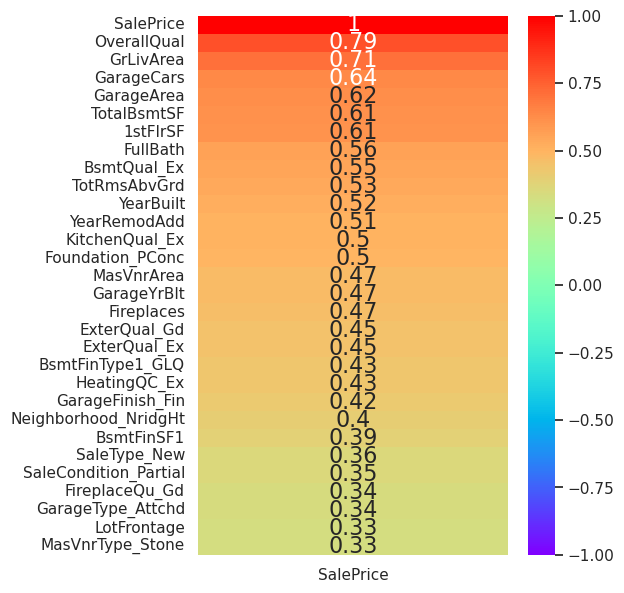

In [9]:
#get first 30 top variables
top_features = train.corr()[['SalePrice']].sort_values(by=['SalePrice'],ascending=False).head(30)
#use heatmap to check the values
plt.figure(figsize=(5,7))
sns.heatmap(top_features,cmap='rainbow',annot=True,annot_kws={"size": 16},vmin=-1)

### Detect Outliers
Create a plot function to check each top variables

In [10]:
# if data is discrete, we will use a diff plot
def plot_data(col, discrete=False):
    if discrete:
        fig, ax = plt.subplots(1,2,figsize=(14,6))
        sns.stripplot(x=col, y='SalePrice', data=train,ax=ax[0])
        sns.countplot(x=col,  data=train, ax=ax[1])
        fig.suptitle(str(col) + ' Analysis')
    else:
        fig, ax = plt.subplots(1,2,figsize=(12,6))
        sns.scatterplot(x=col, y='SalePrice', data=train, ax=ax[0])
        sns.distplot(x=train[col], kde=False, ax=ax[1])
        fig.suptitle(str(col) + ' Analysis')

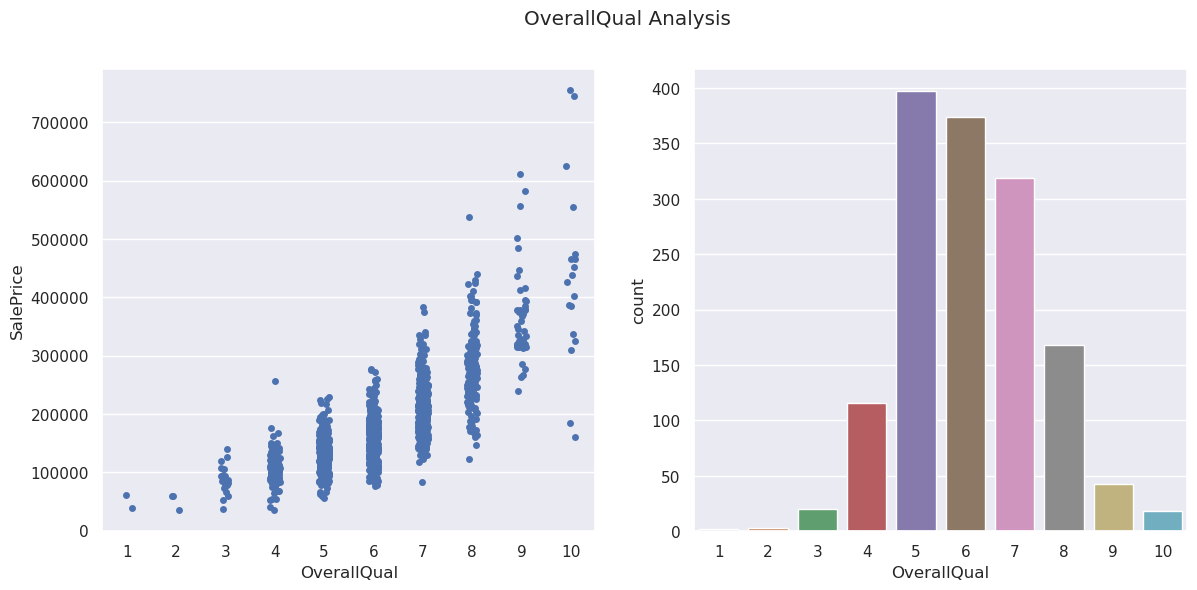

In [11]:
plot_data('OverallQual',True)


There are some outliers on the OverallQual on OverallQual 4, 8, and 10

In [97]:
#drop outliers
train = train.drop(train[(train['OverallQual'] == 10) & (train['SalePrice'] < 200000)].index)
train = train.drop(train[(train['OverallQual'] == 8) & (train['SalePrice'] > 500000)].index)
train = train.drop(train[(train['OverallQual'] == 4) & (train['SalePrice'] > 200000)].index)


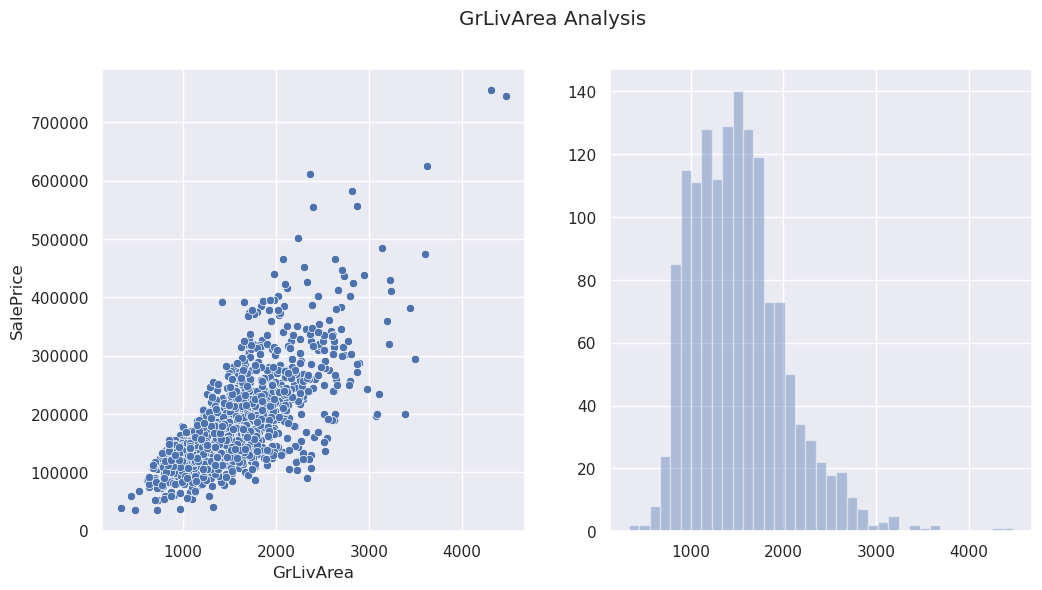

In [13]:
plot_data('GrLivArea')

In [98]:
train = train.drop(train[(train['GrLivArea'] > 4000) & (train['SalePrice'] < 200000)].index)


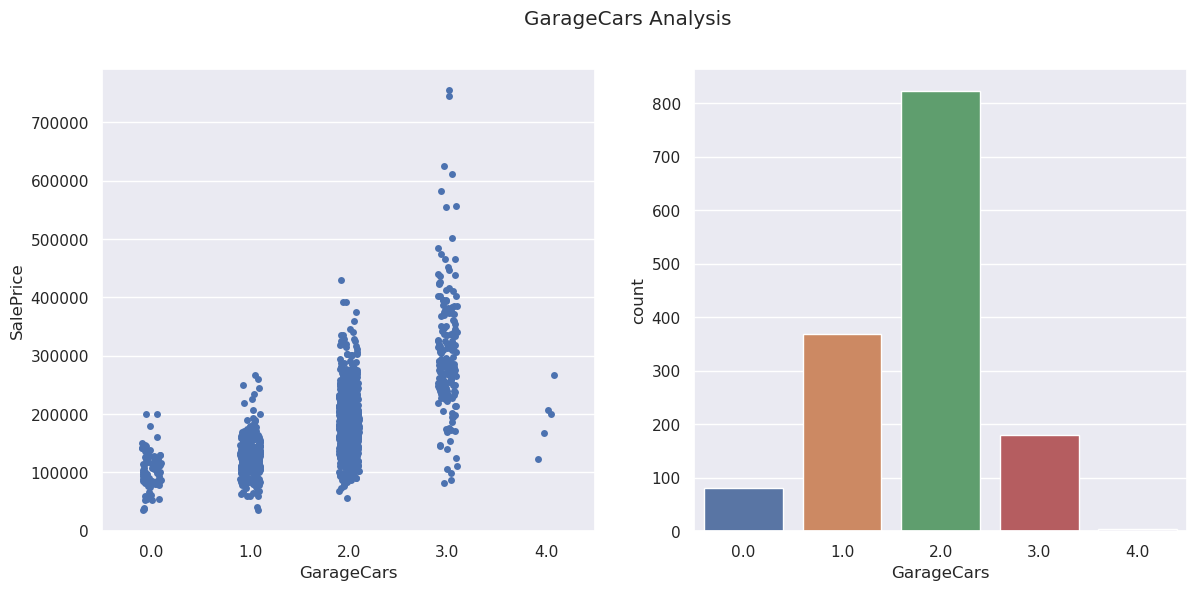

In [15]:
plot_data('GarageCars',True)

In [99]:
train = train.drop(train[(train['GarageCars'] == 3) & (train['SalePrice'] > 700000)].index)


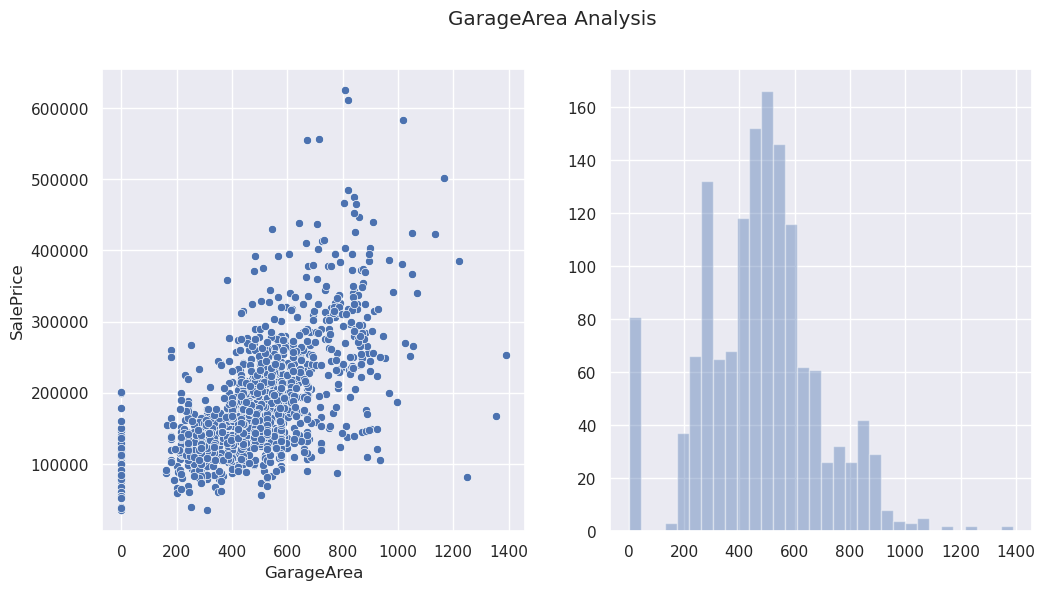

In [17]:
plot_data('GarageArea')

In [100]:
train = train.drop(train[(train['GarageArea'] > 1200) & (train['SalePrice'] < 300000)].index)


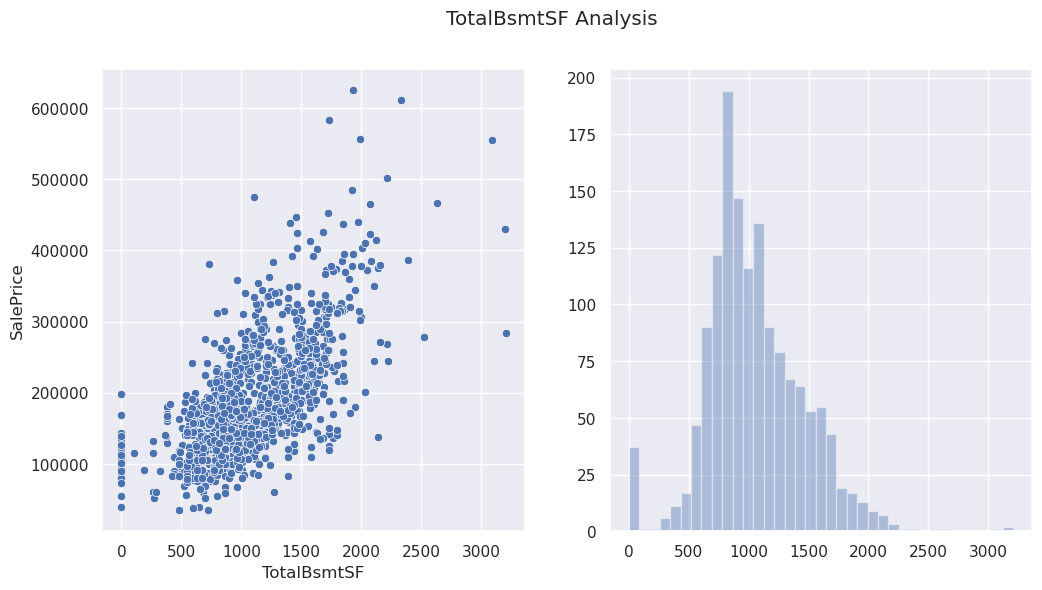

In [19]:
plot_data('TotalBsmtSF')


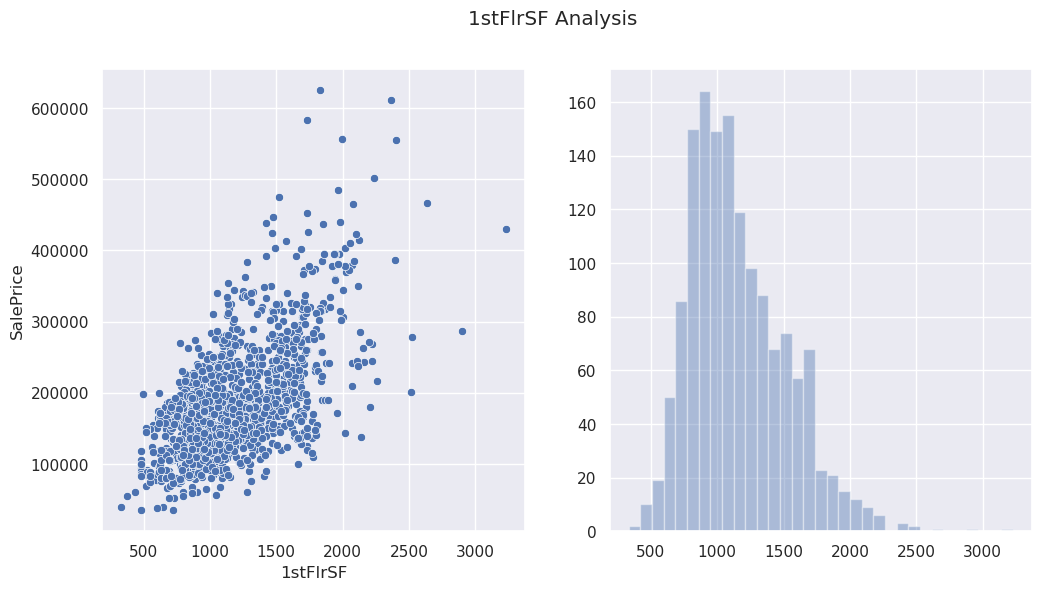

In [20]:
plot_data('1stFlrSF')


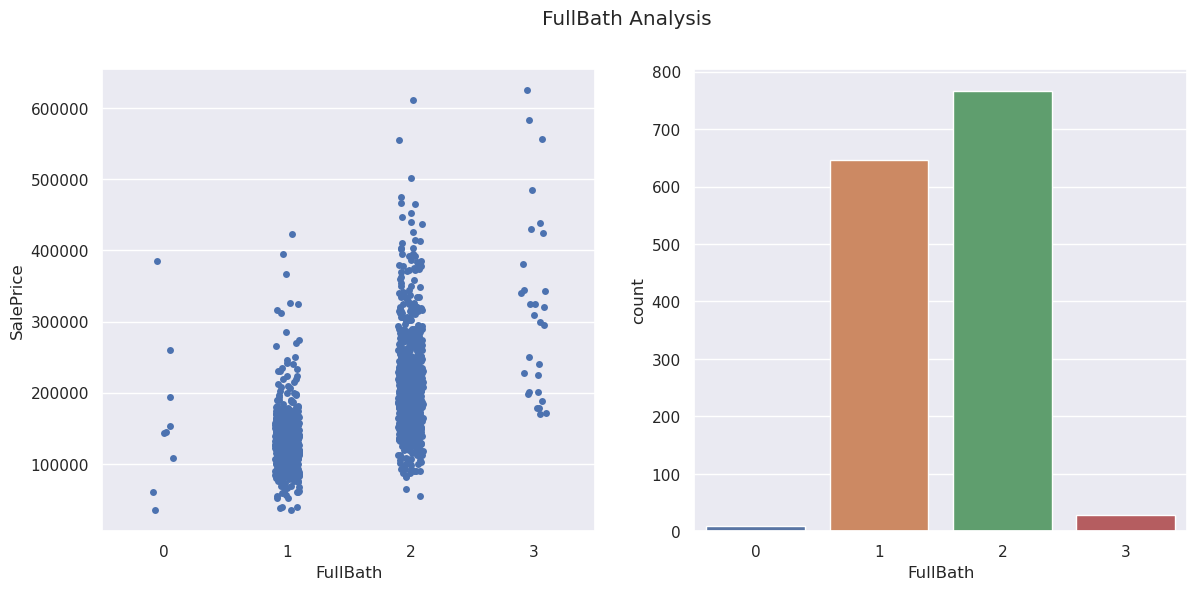

In [21]:
plot_data('FullBath',True)


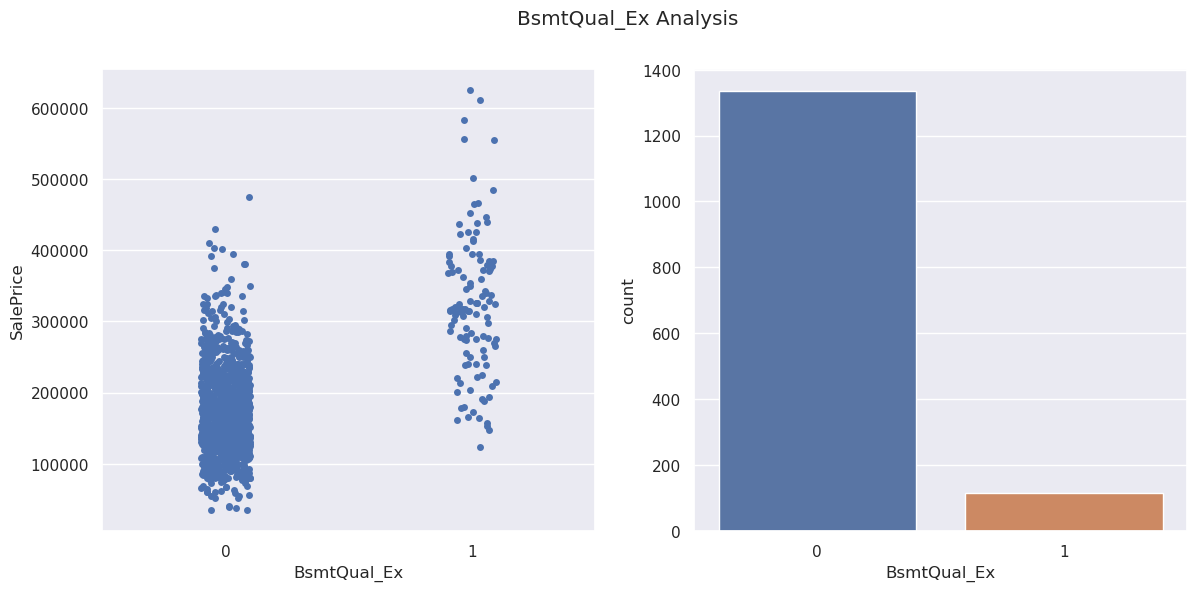

In [22]:
plot_data('BsmtQual_Ex',True)


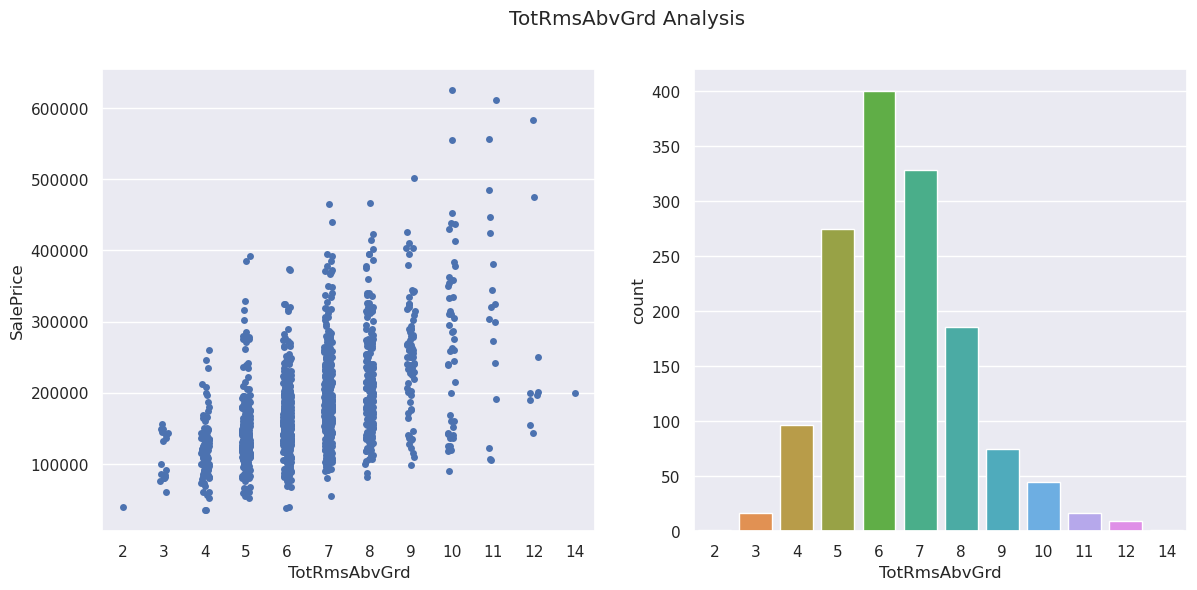

In [23]:
plot_data('TotRmsAbvGrd',True)


### Remove Other Ouliers By Isolation Forest

In [101]:
train.reset_index() # To reset the index

clf = IsolationForest(max_samples = 100, random_state = 42)
clf.fit(train)
y_noano = clf.predict(train)
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
y_noano[y_noano['Top'] == 1].index.values

train = train.iloc[y_noano[y_noano['Top'] == 1].index.values]
train.reset_index(drop = True, inplace = True)
print("Number of Outliers:", y_noano[y_noano['Top'] == -1].shape[0])
print("Number of rows without outliers:", train.shape[0])

Number of Outliers: 14
Number of rows without outliers: 1437


### Make a New Training Data

In [102]:
X = train.copy()
X.drop(['SalePrice'],axis=1,inplace=True) # Dropped the y feature
y = train['SalePrice'].values

In [103]:
X.shape

(1437, 309)

### Modelling

In [72]:
def build_model(hp):
    model = Sequential()
    for i in range(hp.Int('layers', 2, 10)):
        model.add(Dense(units=hp.Int('units_' + str(i)
                                     ,min_value=0
                                     ,max_value=618
                                     ,step=3)
                        ,activation='relu'))
    model.add(Dense(1))
    model.compile(
        optimizer=Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mse',
        metrics=['mse'])
    return model

In [74]:
import tensorflow as tf
tuner = RandomSearch(
    build_model,
    objective='val_mse',
    max_trials=10,
    executions_per_trial=3,
    directory='model_dir',
    project_name='House_Price_Prediction')
 
#stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


In [75]:
tuner.search(X,y,batch_size=128,epochs=200, validation_split=0.2)
#, callbacks=[stop_early]

Trial 10 Complete [00h 02m 03s]
val_mse: 1177558570.6666667

Best val_mse So Far: 535645696.0
Total elapsed time: 00h 13m 59s


In [77]:
tuner.results_summary(num_trials=10)

Results summary
Results in model_dir3/House_Price_Prediction
Showing 10 best trials
Trial summary
Hyperparameters:
layers: 4
units_0: 249
units_1: 102
learning_rate: 0.01
units_2: 105
units_3: 453
units_4: 432
units_5: 81
units_6: 390
units_7: 276
units_8: 336
units_9: 510
Score: 535645696.0
Trial summary
Hyperparameters:
layers: 4
units_0: 156
units_1: 144
learning_rate: 0.01
units_2: 429
units_3: 285
units_4: 315
units_5: 138
units_6: 195
units_7: 183
units_8: 27
units_9: 117
Score: 542536544.0
Trial summary
Hyperparameters:
layers: 3
units_0: 15
units_1: 339
learning_rate: 0.01
units_2: 570
units_3: 78
units_4: 615
units_5: 249
units_6: 63
units_7: 525
units_8: 438
units_9: 582
Score: 545560896.0
Trial summary
Hyperparameters:
layers: 6
units_0: 390
units_1: 438
learning_rate: 0.01
units_2: 237
units_3: 408
units_4: 339
units_5: 300
units_6: 123
units_7: 354
units_8: 558
units_9: 396
Score: 576309824.0
Trial summary
Hyperparameters:
layers: 5
units_0: 195
units_1: 27
learning_rate: 

In [78]:
best_hp = tuner.get_best_hyperparameters(1)[0]

In [79]:
best_hp
model = tuner.hypermodel.build(best_hp)

# Training Model

In [82]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

history = model.fit(x=X,y=y,
          validation_split=0.2,
          batch_size=128,epochs=1000, callbacks=early_stop)

Epoch 1/1000
11/11 [==============================] - 1s 25ms/step - loss: 17896710144.0000 - mse: 17896710144.0000 - val_loss: 4462456320.0000 - val_mse: 4462456320.0000
Epoch 2/1000
11/11 [==============================] - 0s 8ms/step - loss: 4053977344.0000 - mse: 4053977344.0000 - val_loss: 2589896704.0000 - val_mse: 2589896704.0000
Epoch 3/1000
11/11 [==============================] - 0s 9ms/step - loss: 2787384576.0000 - mse: 2787384576.0000 - val_loss: 4516917760.0000 - val_mse: 4516917760.0000
Epoch 4/1000
11/11 [==============================] - 0s 8ms/step - loss: 3163462912.0000 - mse: 3163462912.0000 - val_loss: 2528887808.0000 - val_mse: 2528887808.0000
Epoch 5/1000
11/11 [==============================] - 0s 10ms/step - loss: 2451270144.0000 - mse: 2451270144.0000 - val_loss: 1492656640.0000 - val_mse: 1492656640.0000
Epoch 6/1000
11/11 [==============================] - 0s 9ms/step - loss: 1729380608.0000 - mse: 1729380608.0000 - val_loss: 1295128704.0000 - val_mse: 1295

<AxesSubplot:>

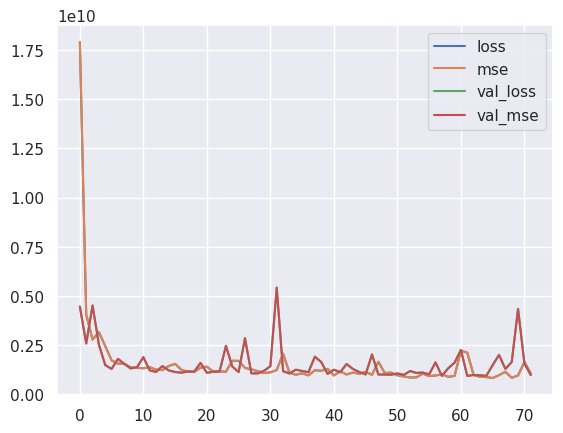

In [115]:
losses = pd.DataFrame(history.history)
losses.plot()

# Prediction

In [129]:
#X_test = scale.transform(test) # Scaling the testing data.
result = model.predict(test) # Prediction using model
result = pd.DataFrame(result,columns=['SalePrice']) # Dataframe
test_Id = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")
result['Id'] = test_Id['Id']

#Submission
submission_predictions = result

submission_predictions.to_csv('submission.csv',index=False)

46/46 [==============================] - 0s 2ms/step


In [130]:
submission_predictions.head()

,SalePrice,Id
0,142192.812500,1461
1,169994.484375,1462
2,199917.218750,1463
3,189614.187500,1464
4,171540.140625,1465
